Optimizasyon algoritmalarını kendiniz kodlamak istemiyorsanız mevcut Python paketlerini kullanabilirsiniz. Bilimsel hesaplama işlemleri için hazırlanan SciPy kütüphanesi içinde kapsamlı bir optimizasyon paketi bulunuyor.

Tam dökümantasyon için: https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize

## Rosenbrock fonksiyonu

In [2]:
def ros(x):
    return 10*(x[1]-x[0]**2)**2 + (1-x[0])**2
def ros_türev(x):
    return np.array([-40*x[0]*x[1] + 40*x[0]**3 -2 + 2*x[0], 20*(x[1]-x[0]**2)])

In [3]:
x0 = [2,5]
res = minimize(ros, x0, jac=ros_türev, method="BFGS")

`minimize()` fonksiyonu çeşitli veriler barındıran bir `OptimizeResult` nesnesi verir.

In [4]:
dir(res)

['fun',
 'hess_inv',
 'jac',
 'message',
 'nfev',
 'nit',
 'njev',
 'status',
 'success',
 'x']

In [5]:
print("Eniyileme noktası :", res.x)
print("Fonksiyon değeri :", res.fun)
print("Türev değeri :", res.jac)
print("Fonksiyon çağrısı sayısı :", res.nfev)
print("İterasyon sayısı :", res.nit)

Eniyileme noktası : [ 1.  1.]
Fonksiyon değeri : 3.569363477597085e-16
Türev değeri : [ -2.40526425e-07   1.19348025e-07]
Fonksiyon çağrısı sayısı : 19
İterasyon sayısı : 16


## Lojistik regresyon

Daha önce kullandığımız lojistik regresyon modelini tekrar yazalım. Yine ortalama sapmayı asgariye indirecek $\theta$ parametre vektörünü tespit etmeye çalışıyoruz, ama bu sefer `scipy.optimize.minimize()` fonksiyonunu kullanacağız. Eniyileme hedefi olan ortalama sapma fonksiyonunu, ve onun türevini veren fonksiyonu, `minimize()` arayüzüne uygun şekilde yazalım.

In [6]:
def model(x, theta):
    # 1 / (1 + exp(-x*theta)
    # theta[0] yanlılık terimidir ve her zaman x[0] = 1 varsayılır.
    
    z = np.dot(x, theta)
   
    # z'nin aşırı büyüyüp overflow yaratmaması için iki yönden kısıtla:
    if np.isscalar(z):
        z = 100 if z>100 else -100 if z<-100 else z
    else: # z bir vektörse sadece gerekli elemanları kısıtla.
        z[z>100] = 100
        z[z<-100] = -100
    
    return 1/(1+np.exp(-z))

def ortsapma(theta, *args):
    # args = (X,y)
    m = args[0].shape[0]
    z = np.dot(args[0],theta)
    if np.isscalar(z):
        z = 100 if z>100 else -100 if z<-100 else z
    else: # z bir vektörse sadece gerekli elemanları kısıtla.
        z[z>100] = 100
        z[z<-100] = -100
    
    J = (1 - args[1])*z + np.log(1 + np.exp(-z))
    return sum(J)/m

def ortsapma_türev(theta, *args):
    # args = (X,y)
    m = args[0].shape[0]
    z = np.dot(args[0],theta)
    if np.isscalar(z):
        z = 100 if z>100 else -100 if z<-100 else z
    else: # z bir vektörse sadece gerekli elemanları kısıtla.
        z[z>100] = 100
        z[z<-100] = -100
    
    grad = np.dot(args[0].transpose(), 1/(1+np.exp(-z)) - args[1])
    return grad/m

In [7]:
train = np.loadtxt("data/mnist_train_3_8.csv",delimiter=",")
deger = 3 # y = 1 ile etiketlenecek rakam
Xtrain = np.copy(train)/train.max() # Veriyi 0-1 arasına ölçeklendir.
Xtrain[:,0] = np.ones(Xtrain.shape[0]) # Sabit terim için birinci sütuna 1'ler koy.

# y değerlerini, hedeflenen rakama göre 0 veya 1 yap
ytrain = np.array([1 if hedef==deger else 0 for hedef in train[:,0]])

m, n = Xtrain.shape

In [8]:
theta_0 = np.random.randn(n)

Burada elimizdeki optimizasyon probleminin boyutu çok büyük (784). Böyle problemlerde BFGS kullanmak, Hesse matrisinin büyüklüğünden dolayı çok zorlayıcı olacaktır. Onun yerine, sınırlı sayıda veri kullanan L-BFGS-B algoritmasını kullanacağız.

In [9]:
res = minimize(ortsapma, theta_0, args=(Xtrain, ytrain), jac=ortsapma_türev, method="L-BFGS-B")

In [10]:
test = np.loadtxt("data/mnist_test_3_8.csv",delimiter=",")
Xtest = np.copy(test)/test.max() # Veriyi ölçeklendir
Xtest[:,0] = np.ones(Xtest.shape[0]) # Sabit terim için birinci sütuna 1'ler koy.

# y değerlerini, hedeflenen rakama göre 0 veya 1 yap
ytest = np.array([1 if hedef==deger else 0 for hedef in test[:,0]])

In [11]:
tahminler = np.rint( model(Xtest, res.x) )
print("Doğruluk =",sum(np.equal( tahminler, ytest)) / len(tahminler) )

Doğruluk = 0.959173387097


### Çalışma: L2 düzenlileştirme terimi

`ortsapma` ve `ortsapma_türev` fonksiyonlarını değiştirerek L2 _düzenlileştirme terimi_ $\frac{\lambda}{2m} \sum_{j=1}^{n}\theta^2$ ekleyin. $\theta_0$ teriminin eklenmemesi gerektiğini unutmayın.

In [12]:
def ortsapma(theta, *args):
    # args = (X,y,lambda)
    m = args[0].shape[0]
    lam = args[2] # regularization parameter
    z = np.dot(args[0],theta)
    if np.isscalar(z):
        z = 100 if z>100 else -100 if z<-100 else z
    else: # z bir vektörse sadece gerekli elemanları kısıtla.
        z[z>100] = 100
        z[z<-100] = -100
    
    J = (1 - args[1])*z + np.log(1 + np.exp(-z))
    J += 0.5*lam*np.dot(theta[1:],theta[1:])
    return sum(J)/m

def ortsapma_türev(theta, *args):
    # args = (X,y,lambda)
    m = args[0].shape[0]
    lam = args[2]
    z = np.dot(args[0],theta)
    if np.isscalar(z):
        z = 100 if z>100 else -100 if z<-100 else z
    else: # z bir vektörse sadece gerekli elemanları kısıtla.
        z[z>100] = 100
        z[z<-100] = -100
    
    grad = np.dot(args[0].transpose(), 1/(1+np.exp(-z)) - args[1])
    grad[1:] += lam * theta[1:]
    return grad/m

$\lambda$ 0 ve 10 arasında olacak şekilde farklı düzenlileştirme parametreleri ile eniyileştirme yapın, test kümesiyle karşılaştırarak doğruluklarını hesaplayın.

In [13]:
lamlist = np.arange(0,11)
doğruluk = []
for lam in lamlist:
    res = minimize(ortsapma, theta_0, args=(Xtrain, ytrain, lam), jac=ortsapma_türev, method="L-BFGS-B")
    tahminler = np.rint( model(Xtest, res.x) )
    doğruluk.append(sum(np.equal( tahminler, ytest)) / len(tahminler) )

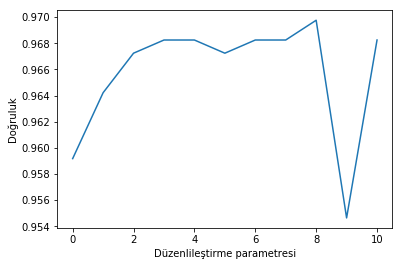

In [14]:
plt.plot(lamlist, doğruluk)
plt.xlabel("Düzenlileştirme parametresi")
plt.ylabel("Doğruluk");

Ortaya çıkan grafiğin biçimi `theta0` vektörünün değerlerine göre değişebilir. Değişik rastgele başlangıç vektörleriyle tekrar deneyebilirsiniz.